In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score
import shap
import optuna
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [53]:
df= pd.read_csv('full_df_with_cluster.csv')
df = df.dropna(subset=['pv_for_trip.'])

In [54]:
df_cluster1 = df[df['pred_class_lca5'] == 1]
df_cluster2 = df[df['pred_class_lca5'] == 2]
df_cluster3 = df[df['pred_class_lca5'] == 3]
df_cluster4 = df[df['pred_class_lca5'] == 4]
df_cluster5 = df[df['pred_class_lca5'] == 5]

In [55]:
df_cluster1.to_csv("cluster_1.csv", index=False)
df_cluster2.to_csv("cluster_2.csv", index=False)
df_cluster3.to_csv("cluster_3.csv", index=False)
df_cluster4.to_csv("cluster_4.csv", index=False)
df_cluster5.to_csv("cluster_5.csv", index=False)

In [56]:
X = df_cluster1[['sex','age_group','spanish','driving_license_binary','educ_group','main_activity_group','prof_status_group','transport_card_binary','mobility_issue','ppl_hh','pp_4age_hh','vehicles_hh','private_parking.','electric.','trips_hh','primary_reason','distance_km','rush_hour_75.','travel_freq','pv_for_trip.','temp','precip']]
y = df_cluster1[['primary_mode_group']]

In [57]:
categorical_cols = ['sex', 'age_group','spanish','driving_license_binary','educ_group','main_activity_group','prof_status_group','transport_card_binary','mobility_issue','private_parking.','electric.','primary_reason','pv_for_trip.']

In [58]:
X_dummies = pd.get_dummies(X, columns=categorical_cols)

In [59]:
rename_dict = {
    'rush_hour_75.' : 'rush_hour_75%',
    'ppl_hh': 'household_size',
    'pp_4age_hh': 'household_members_4plus',
    'vehicles_hh': 'household_vehicles',
    'trips_hh': 'household_trip_count',
    'sex_1': 'gender_male',
    'sex_2': 'gender_female',
    'age_group_1': 'age_below_18',
    'age_group_2': 'age_18_to_29',
    'age_group_3': 'age_30_to_59',
    'age_group_4': 'age_60plus',
    'spanish_1': 'spanish_nationality',
    'spanish_2': 'spanish_nationality_no',
    'driving_license_binary_0': 'has_driving_license_no',
    'driving_license_binary_1': 'has_driving_license',
    'educ_group_1': 'education_primary_or_less',
    'educ_group_2': 'education_secondary',
    'educ_group_3': 'education_bachelor_or_higher',
    'educ_group_4': 'education_other',
    'main_activity_group_1': 'main_activity_employed',
    'main_activity_group_2': 'main_activity_retired',
    'main_activity_group_3': 'main_activity_unemployed',
    'main_activity_group_4': 'main_activity_student',
    'prof_status_group_1': 'prof_status_public_employee',
    'prof_status_group_2': 'prof_status_private_employee',
    'prof_status_group_3': 'prof_status_own_or_family_business',
    'prof_status_group_4': 'prof_status_other',
    'prof_status_group_5': 'prof_status_unemployed',
    'transport_card_binary_0': 'has_transport_card_no',
    'transport_card_binary_1': 'has_transport_card_yes',
    'mobility_issue_1': 'mobility_issue',
    'mobility_issue_2': 'mobility_issue_no',
    'private_parking._0': 'private_parking_no',
    'private_parking._1': 'private_parking_yes',
    'electric._0': 'electric_or_hybrid_transport_no',
    'electric._1': 'electric_or_hybrid_transport',
    'primary_reason_1': 'trip_reason_work',
    'primary_reason_2': 'trip_reason_study',
    'primary_reason_3': 'trip_reason_entertainment',
    'primary_reason_4': 'trip_reason_accompany_others',
    'primary_reason_5': 'trip_reason_personal_matters',
    'primary_reason_6': 'trip_reason_other',
    'pv_for_trip._1.0':'private_vehicle_used',
    'pv_for_trip._2.0':'private_vehicle_used_no'
}

In [60]:
X_dummies = X_dummies.rename(columns=rename_dict)

In [61]:
# make sure categories start from 0
y['primary_mode_group'] = y['primary_mode_group'] - 1

/var/folders/ps/rsyy3fxx1fq6dzs0frkt8hl80000gn/T/ipykernel_21831/1151536143.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['primary_mode_group'] = y['primary_mode_group'] - 1


In [62]:
y = y.values.ravel()

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, test_size=0.3, random_state=42)

In [64]:
def rf_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 500)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    
    rf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42
    )
    
    score = cross_val_score(rf, X_train, y_train, cv=5, scoring='accuracy')
    return score.mean()

rf_study = optuna.create_study(direction="maximize")
rf_study.optimize(rf_objective, n_trials=20)

print("Best RF parameters:", rf_study.best_params)

[I 2025-04-09 14:22:10,414] A new study created in memory with name: no-name-4ffd0751-1d30-49e3-b954-c7465c2f6b65
[I 2025-04-09 14:22:54,270] Trial 0 finished with value: 0.7787946858498896 and parameters: {'n_estimators': 485, 'max_depth': 20}. Best is trial 0 with value: 0.7787946858498896.
[I 2025-04-09 14:23:13,612] Trial 1 finished with value: 0.7161436823440177 and parameters: {'n_estimators': 353, 'max_depth': 10}. Best is trial 0 with value: 0.7787946858498896.
[I 2025-04-09 14:23:17,282] Trial 2 finished with value: 0.6332456973507903 and parameters: {'n_estimators': 148, 'max_depth': 3}. Best is trial 0 with value: 0.7787946858498896.
[I 2025-04-09 14:23:25,704] Trial 3 finished with value: 0.686493580355488 and parameters: {'n_estimators': 226, 'max_depth': 6}. Best is trial 0 with value: 0.7787946858498896.
[I 2025-04-09 14:23:42,723] Trial 4 finished with value: 0.7700762370100254 and parameters: {'n_estimators': 199, 'max_depth': 18}. Best is trial 0 with value: 0.7787946

Best RF parameters: {'n_estimators': 485, 'max_depth': 20}


In [65]:
def xgb_objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 500)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3)
    
    model = XGBClassifier(
        objective='multi:softprob',
        num_class = len(np.unique(y)),
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        eval_metric='mlogloss',
        random_state=42
    )
    
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    return score.mean()

xgb_study = optuna.create_study(direction="maximize")
xgb_study.optimize(xgb_objective, n_trials=20)
print("Best XGB params:", xgb_study.best_params)

[I 2025-04-09 14:31:23,936] A new study created in memory with name: no-name-2e69b48e-8b69-4555-afb6-8d2130312dc5
[I 2025-04-09 14:32:07,000] Trial 0 finished with value: 0.7645638854696586 and parameters: {'n_estimators': 220, 'max_depth': 13, 'learning_rate': 0.03920318499050226}. Best is trial 0 with value: 0.7645638854696586.
[I 2025-04-09 14:32:54,702] Trial 1 finished with value: 0.7771733823175926 and parameters: {'n_estimators': 198, 'max_depth': 20, 'learning_rate': 0.1107206153115653}. Best is trial 1 with value: 0.7771733823175926.
[I 2025-04-09 14:33:47,532] Trial 2 finished with value: 0.7684548815619586 and parameters: {'n_estimators': 452, 'max_depth': 9, 'learning_rate': 0.1551689272628172}. Best is trial 1 with value: 0.7771733823175926.
[I 2025-04-09 14:38:27,525] Trial 3 finished with value: 0.7729942926398493 and parameters: {'n_estimators': 441, 'max_depth': 13, 'learning_rate': 0.07298985655594294}. Best is trial 1 with value: 0.7771733823175926.
[I 2025-04-09 15:

Best XGB params: {'n_estimators': 220, 'max_depth': 20, 'learning_rate': 0.09997365471361738}


In [66]:
#Train final models with best hyperparameters 
best_rf = RandomForestClassifier(**rf_study.best_params, random_state=42)
best_rf.fit(X_train, y_train)
y_pred_rf = best_rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print("Final RF accuracy:", rf_accuracy)

best_xgb = XGBClassifier(
    **xgb_study.best_params,
    objective='multi:softprob',
    num_class = len(np.unique(y)),
    eval_metric='mlogloss',
    random_state=42
)
best_xgb.fit(X_train, y_train)
y_pred_xgb = best_xgb.predict(X_test)
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
print("Final XGB accuracy:", xgb_accuracy)

Final RF accuracy: 0.7908716483147011
Final XGB accuracy: 0.7912919223333613


In [67]:
#Model performance weights
rf_f1 = f1_score(y_test, best_rf.predict(X_test), average='macro')
xgb_f1 = f1_score(y_test, best_xgb.predict(X_test), average='macro')

rf_weight = rf_f1 / (rf_f1 + xgb_f1)
xgb_weight = xgb_f1 / (rf_f1 + xgb_f1)

print(f" F1 score: {rf_f1:.4f}, XGB F1 score: {xgb_f1:.4f}")
print(f"RF weight: {rf_weight:.4f}, XGB weight: {xgb_weight:.4f}")

 F1 score: 0.6080, XGB F1 score: 0.6135
RF weight: 0.4977, XGB weight: 0.5023


In [68]:
#Use a sub sample representative enough for time reasons 
X_test_sample = X_test.sample(n=3000, random_state=42)

In [69]:
explainer_rf = shap.TreeExplainer(best_rf)
shap_values_rf = explainer_rf.shap_values(X_test_sample)

In [70]:
explainer_xgb = shap.TreeExplainer(best_xgb)
shap_values_xgb = explainer_xgb.shap_values(X_test_sample)

SHAP PER CLASS COMBINED XGB AND RF

Summary plot for class 0:


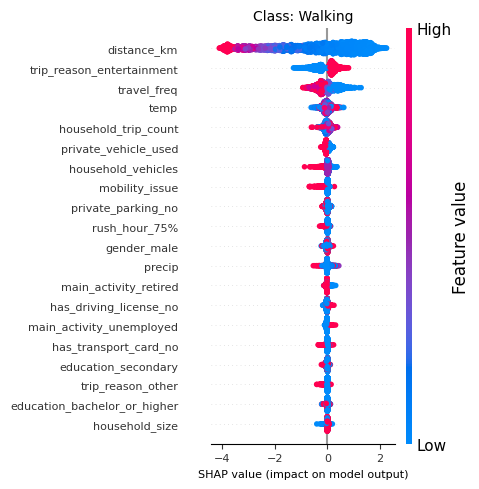

Summary plot for class 1:


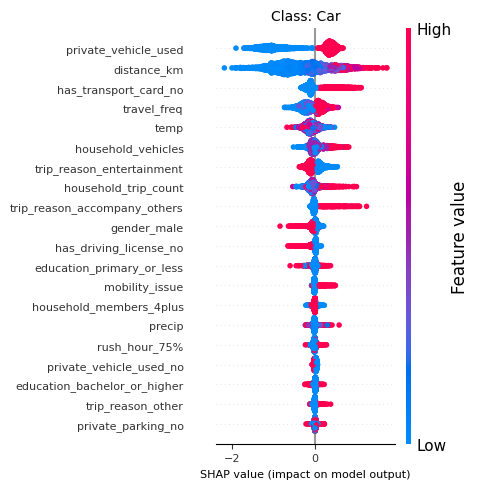

Summary plot for class 2:


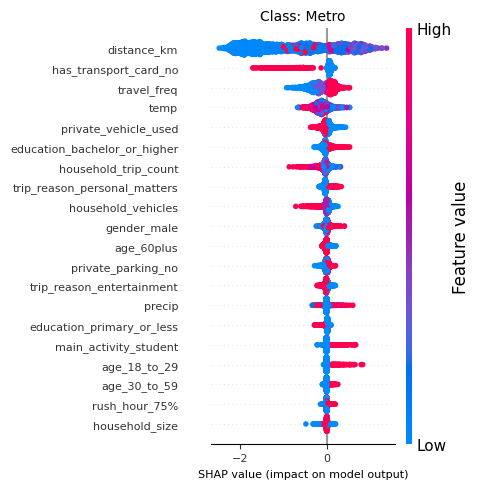

Summary plot for class 3:


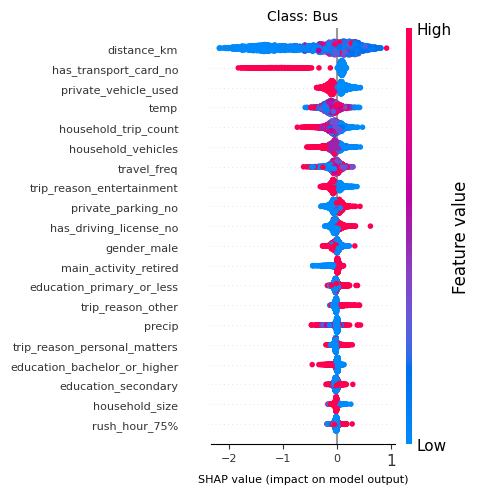

Summary plot for class 4:


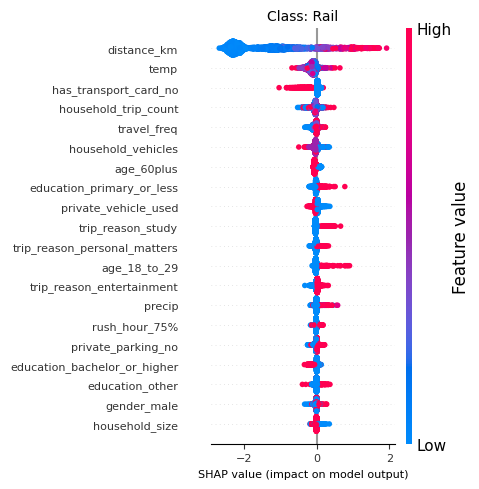

Summary plot for class 5:


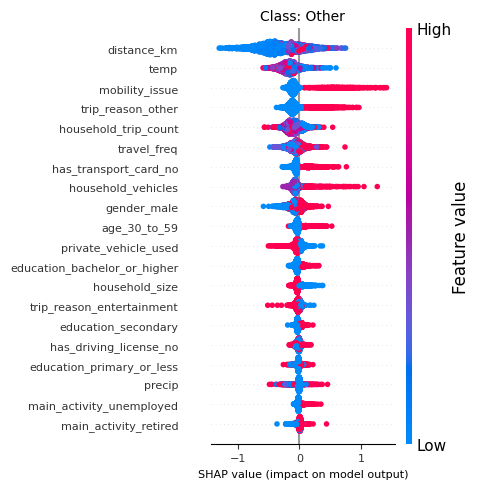

In [71]:
n_classes = shap_values_rf.shape[2]
class_names = ['Walking',"Car",'Metro', 'Bus','Rail','Other']
for c in range(n_classes):
    shap_rf_c = shap_values_rf[:, :, c]
    shap_xgb_c = shap_values_xgb[:, :, c]
    
    combined_shap_c = rf_weight *  shap_rf_c + xgb_weight * shap_xgb_c
    
    print(f"Summary plot for class {c}:")
    shap.summary_plot(combined_shap_c, X_test_sample, feature_names=X_test_sample.columns, plot_type="dot", show=False,plot_size=(5,5))
    class_name = class_names[c]
    plt.title(f"Class: {class_name}", fontsize=10)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)
    plt.xlabel("SHAP value (impact on model output)", fontsize=8)
    plt.tight_layout()
    plt.show()

GLOBAL SHAP 

In [72]:
# use predicted probabilities for each class as weights for per-class SHAP values
p_rf = best_rf.predict_proba(X_test_sample)
p_xgb = best_xgb.predict_proba(X_test_sample)
p_rf_reshaped = p_rf[:, None, :]  
p_xgb_reshaped = p_xgb[:, None, :]

In [73]:
phi_rf_weighted = rf_weight * p_rf_reshaped * shap_values_rf 
phi_xgb_weighted = xgb_weight * p_xgb_reshaped * shap_values_xgb

In [74]:
phi_combined = phi_rf_weighted + phi_xgb_weighted
phi_combined_abs = np.abs(phi_combined)
phi_summed_over_classes = np.sum(phi_combined_abs, axis=2)

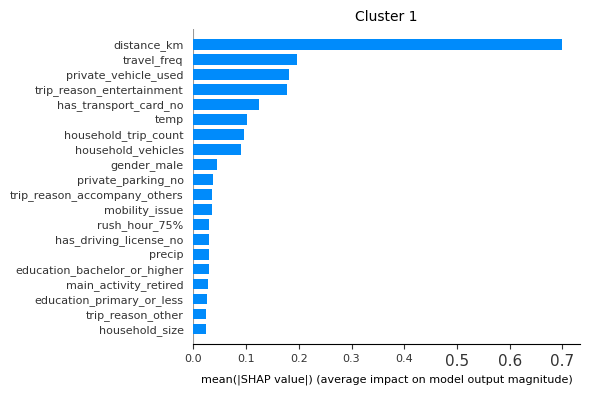

In [75]:
shap.summary_plot(phi_summed_over_classes, X_test_sample, feature_names=X_test_sample.columns, plot_type="bar", plot_size=(6,4), show=False)
plt.title("Cluster 1", fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel("mean(|SHAP value|) (average impact on model output magnitude)", fontsize=8)
plt.tight_layout()
plt.show()